# Classification mnist

The objective of this notebook is train classification model used mnist data.

## Dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist.data, mnist.target
print(X.shape)
X

(70000, 784)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
print(y.shape)
y

(70000,)


array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

5


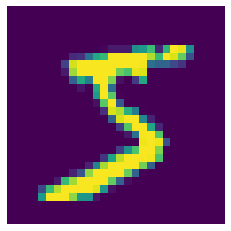

In [5]:
import numpy as np
from matplotlib import pyplot as plt

def plot_digit(image_param: np.ndarray):
    image = image_param.reshape(28, 28)
    plt.imshow(image)
    plt.axis('off')


some_index = 0
some_digit = X[some_index]
print(y[some_index])
plot_digit(some_digit)

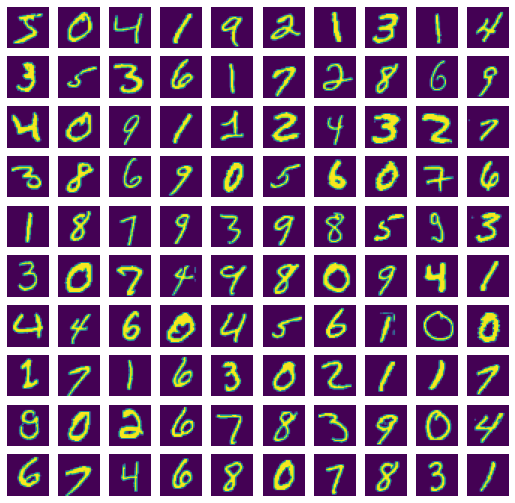

In [6]:
plt.figure(figsize=(9, 9))

for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Train binary classifier

Binary classifier is a model can predict between two classes, in this case we create a "5-detector" this can detect if the image is number 5 or not.

In [8]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [9]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring accuracy using cross validation

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96528571, 0.9662381 , 0.95842857])

In [11]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [12]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3)

array([0.9102381, 0.9102381, 0.9102381])

### Confusion Matrix

In confusion matrix the rows represents the real classes, when the columns represent predicted classes.

In the 5-detector case:

|                         | is not five | is five |
|-------------------------|-------------|---------|
| **predict is not five** | 53272       | 1307    |
| **predict is five**     | 1077        | 4344    |

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[56363,   982],
       [ 1234,  4421]], dtype=int64)

In [14]:
# perfect predict
confusion_matrix(y_train_pred, y_train_pred)

array([[57597,     0],
       [    0,  5403]], dtype=int64)

### Precision and Recall

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8182491208587822

In [16]:
recall_score(y_train_5, y_train_pred)

0.7817860300618922

In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7996020980285767

### Precision/Recall Trade-off

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([7653.18937069])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method='decision_function'
)

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

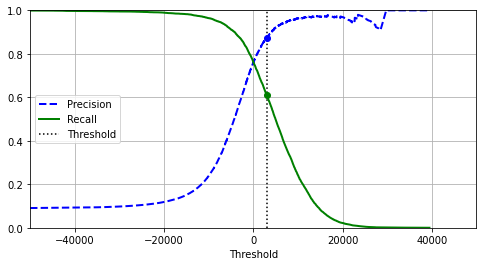

In [23]:
def plot_precision_recall_vs_threshold(precisions: np.ndarray, recalls: np.ndarray, thresholds: np.ndarray):
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.vlines(threshold, 0, 1, 'k', 'dotted', label='Threshold')
    idx = (thresholds >= threshold).argmax()
    plt.plot(thresholds[idx], precisions[idx], 'bo')
    plt.plot(thresholds[idx], recalls[idx], 'go')
    plt.axis([-50_000, 50_000, 0, 1])
    plt.grid()
    plt.xlabel('Threshold')
    plt.legend(loc='center left')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### The ROC curve

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_train_pred)

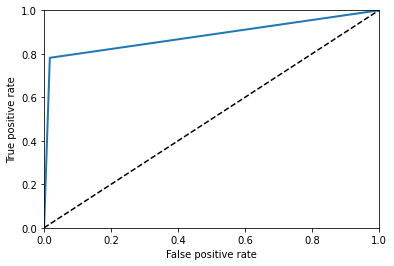

In [25]:
def plot_roc_curve(fpr: np.ndarray, tpr: np.ndarray, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

plot_roc_curve(fpr, tpr)

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_train_pred)

0.8823308038529881

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5,
    cv=3, method='predict_proba'
)
y_probas_forest[:2]

array([[0.83, 0.17],
       [0.99, 0.01]])

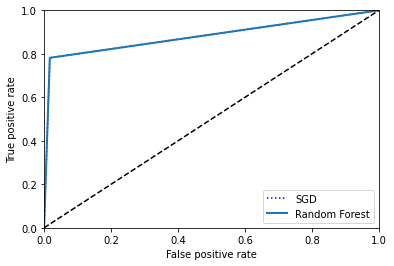

In [28]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_train_pred)
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9982353522997718

## Multiclass Classification

In [30]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [31]:
# verify if variable some_digit (the value is 5) is a large number (more or equals to 7) and if is odd number
knn_clf.predict([some_digit])

array([[False,  True]])

In [32]:
# verify metrics
# it's metric if all labels is same importance

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9767133796163985

In [33]:
# verify metrics
# it's metric if are more labels from specific class

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9781767664691019

## Multi output Classification

In [34]:
def create_noise(data):
    return np.random.randint(0, 100, (len(data), 784))

noise = create_noise(X_train)
X_train_mod = X_train + noise
noise = create_noise(X_test)
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

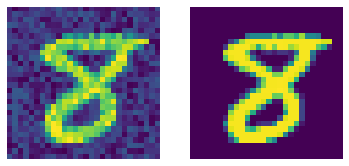

In [35]:
# data with noise
plt.subplot(121)
plot_digit(X_test_mod[0])
# data without noise
plt.subplot(122)
plot_digit(y_test_mod[0])

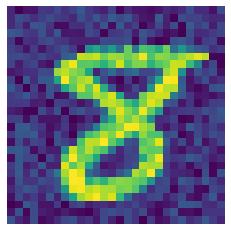

In [36]:
some_digit_mod = X_test_mod[some_index]
plot_digit(some_digit_mod)

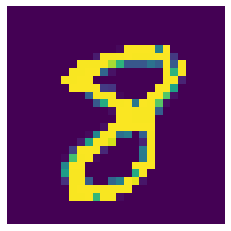

In [37]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([some_digit_mod])
plot_digit(clean_digit)